# Experiment 3:
## U-Net: Prediction of Human Pose Masks & Softmax Regression Values

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing import image
import cv2
from keras.utils import multi_gpu_model
from scipy import ndimage
from keras.utils import to_categorical
from keras.models import load_model
from keras import losses
from keras import backend as K 

Using TensorFlow backend.


## Create Training and Validation Sets

In [3]:
image_adr = 'SMALL_5K_IMAGES/'
mask_adr = 'SMALL_5K_MASKS/'
heatmap_adr = 'SMALL_5K_HEATMAPS/'
heatmap_loc = 'JOINTPLACE/'

#image_adr = 'BIG_18K_IMAGES/'
#mask_adr = 'BIG_18K_MASKS/'

images = sorted(os.listdir(image_adr))
masked = sorted(os.listdir(mask_adr))
heatmaps = sorted(os.listdir(heatmap_adr))
heat_locs = sorted(os.listdir(heatmap_loc))

In [4]:
print(len(images))
print(len(masked))

5000
5000


In [5]:
np.random.seed(23)
order = np.random.permutation(len(images))
X_train = order[:int(0.8*len(order))]
X_valid = order[int(0.8*len(order)):]
print(len(X_train))
print(len(X_valid))

4000
1000


***

## U-Net Model

In [6]:
smooth = 1e-6

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(y_pred[0,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_coef_hard(y_pred, y_true):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(np.argmax(y_pred[0,:,:,:], axis=-1).astype('float32'))
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [7]:
def create_unet(min_neuron):
    
    inputs = Input((None, None, 3))
    
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(min_neuron*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    drop6 = Dropout(0.3)(conv6)
    
    up7 = Conv2D(min_neuron*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    drop7 = Dropout(0.3)(conv7)

    up8 = Conv2D(min_neuron*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    drop8 = Dropout(0.3)(conv8)

    up9 = Conv2D(min_neuron, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    mask_out = Conv2D(2, 1, activation='softmax', name='output1')(conv9)
    heatmap_out = Conv2D(26, 1, activation='softmax', name='output2')(conv9)   # For HeatMaps
    
    model = Model(inputs=inputs, outputs=[mask_out, heatmap_out])    
    model.compile(optimizer = Adam(lr=2e-5), loss={'output1': dice_loss, 'output2': 'categorical_crossentropy'}, metrics={'output1': dice_coef})

    return model

In [19]:
def generator(X_data, y_data, order):
    
    samples_per_epoch = len(order)
    number_of_batches = samples_per_epoch
    
    counter=0
    
    while 1:
        
        X_batch = cv2.cvtColor(cv2.imread(image_adr + X_data[order[counter]]), cv2.COLOR_BGR2RGB).astype('float32')
        X_batch /= 255
        
        r = X_batch.shape[0]
        c = X_batch.shape[1]
        r_pad = 0
        c_pad = 0
        
        while r % 16 != 0:
            r_pad += 1
            r += 1
            
        while c % 16 != 0:
            c_pad += 1
            c += 1
            
        X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X_batch = np.expand_dims(X_batch, axis=0)

        y_heatmap_loc = np.load(heatmap_loc + heat_locs[order[counter]])  # For Heatmaps
        y_heatmap_loc = np.pad(y_heatmap_loc, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        
        y_heatmap = cv2.imread(heatmap_adr + y_data[order[counter]], 0).astype('float32')/255  # For Heatmaps
        y_heatmap = np.pad(y_heatmap, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        
        y_map = np.zeros(y_heatmap_loc.shape + (26,))
        
        for i in range(1,26):
            y_map[(y_heatmap_loc == i), i] = y_heatmap[(y_heatmap_loc == i)]
            
        y_map[(y_heatmap_loc == 0),0] = 1
        
        y_map = np.expand_dims(y_map, 0)
        
        y_mask = (cv2.imread(mask_adr + y_data[order[counter]], 0) > 200).astype('float32') # For Mask
        y_mask = np.pad(y_mask, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y_mask = to_categorical(y_mask, 2) # For Mask
        y_mask = np.expand_dims(y_mask, 0)

        counter += 1
        
        yield X_batch, {'output1': y_mask, 'output2': y_map}

        #restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [20]:
model1 = create_unet(64)
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, None, None, 6 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, None, None, 6 36928       conv2d_89[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, None, None, 6 0           conv2d_90[0][0]                  
__________________________________________________________________________________________________
conv2d_91 

***

## Model Training

### Small Dataset Training

In [21]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, 
                             monitor='val_loss', save_best_only=True, mode='auto') 


history = model1.fit_generator(generator(images, masked, X_train),
                              epochs=100,
                              steps_per_epoch = len(X_train),
                              validation_data = generator(images, masked, X_valid),
                              validation_steps = len(X_valid),
                              callbacks=[checkpoint])

Epoch 1/100
4000/4000 [==============================] - 266s 66ms/step - loss: 0.3428 - output1_loss: 0.2789 - output2_loss: 0.0639 - output1_dice_coef: 0.7211 - val_loss: 0.2768 - val_output1_loss: 0.1902 - val_output2_loss: 0.0867 - val_output1_dice_coef: 0.8098

Epoch 00001: val_loss improved from inf to 0.27685, saving model to model-001-0.276847.h5
Epoch 2/100
4000/4000 [==============================] - 263s 66ms/step - loss: 0.1912 - output1_loss: 0.1546 - output2_loss: 0.0366 - output1_dice_coef: 0.8454 - val_loss: 0.2029 - val_output1_loss: 0.1456 - val_output2_loss: 0.0573 - val_output1_dice_coef: 0.8544

Epoch 00002: val_loss improved from 0.27685 to 0.20291, saving model to model-002-0.202905.h5
Epoch 3/100
4000/4000 [==============================] - 263s 66ms/step - loss: 0.1648 - output1_loss: 0.1344 - output2_loss: 0.0304 - output1_dice_coef: 0.8656 - val_loss: 0.1794 - val_output1_loss: 0.1382 - val_output2_loss: 0.0411 - val_output1_dice_coef: 0.8618

Epoch 00003: va

4000/4000 [==============================] - 262s 66ms/step - loss: 0.0490 - output1_loss: 0.0377 - output2_loss: 0.0113 - output1_dice_coef: 0.9623 - val_loss: 0.0987 - val_output1_loss: 0.0840 - val_output2_loss: 0.0148 - val_output1_dice_coef: 0.9160

Epoch 00049: val_loss did not improve from 0.09772
Epoch 50/100
4000/4000 [==============================] - 262s 66ms/step - loss: 0.0481 - output1_loss: 0.0370 - output2_loss: 0.0112 - output1_dice_coef: 0.9630 - val_loss: 0.0966 - val_output1_loss: 0.0820 - val_output2_loss: 0.0147 - val_output1_dice_coef: 0.9180

Epoch 00050: val_loss improved from 0.09772 to 0.09664, saving model to model-050-0.096645.h5
Epoch 51/100
4000/4000 [==============================] - 263s 66ms/step - loss: 0.0473 - output1_loss: 0.0363 - output2_loss: 0.0110 - output1_dice_coef: 0.9637 - val_loss: 0.0979 - val_output1_loss: 0.0836 - val_output2_loss: 0.0143 - val_output1_dice_coef: 0.9164

Epoch 00051: val_loss did not improve from 0.09664
Epoch 52/100



Epoch 00073: val_loss did not improve from 0.09404
Epoch 74/100
4000/4000 [==============================] - 263s 66ms/step - loss: 0.0358 - output1_loss: 0.0275 - output2_loss: 0.0083 - output1_dice_coef: 0.9725 - val_loss: 0.0966 - val_output1_loss: 0.0820 - val_output2_loss: 0.0146 - val_output1_dice_coef: 0.9180

Epoch 00074: val_loss did not improve from 0.09404
Epoch 75/100
4000/4000 [==============================] - 263s 66ms/step - loss: 0.0353 - output1_loss: 0.0272 - output2_loss: 0.0081 - output1_dice_coef: 0.9728 - val_loss: 0.0966 - val_output1_loss: 0.0822 - val_output2_loss: 0.0144 - val_output1_dice_coef: 0.9178

Epoch 00075: val_loss did not improve from 0.09404
Epoch 76/100
4000/4000 [==============================] - 263s 66ms/step - loss: 0.0352 - output1_loss: 0.0272 - output2_loss: 0.0081 - output1_dice_coef: 0.9728 - val_loss: 0.0936 - val_output1_loss: 0.0795 - val_output2_loss: 0.0140 - val_output1_dice_coef: 0.9205

Epoch 00076: val_loss improved from 0.0940

***

## Model Performance

### Small Dataset

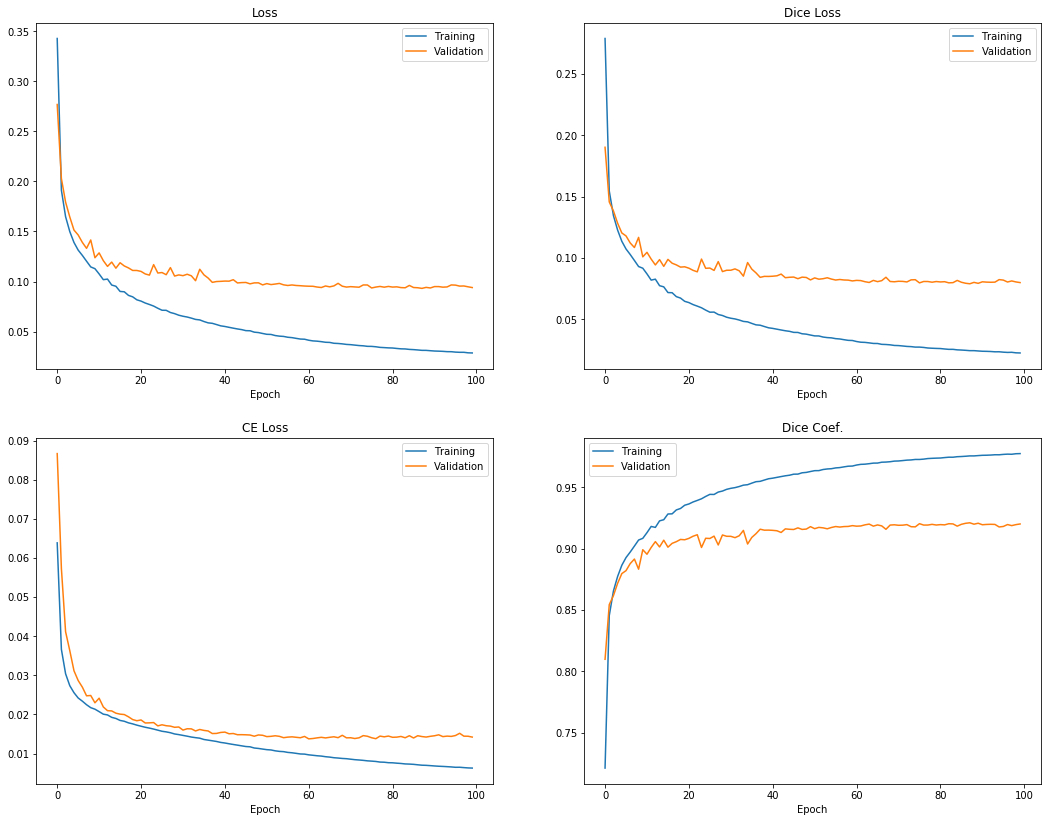

In [22]:
ad = history.history

f, ax = plt.subplots(2,2, figsize=(18,14))

ax[0,0].plot(ad['loss'], label='Training')
ax[0,0].plot(ad['val_loss'], label='Validation')
ax[0,0].set_title('Loss')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend()

ax[0,1].plot(ad['output1_loss'], label='Training')
ax[0,1].plot(ad['val_output1_loss'], label='Validation')
ax[0,1].set_title('Dice Loss')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend()

ax[1,0].plot(ad['output2_loss'], label='Training')
ax[1,0].plot(ad['val_output2_loss'], label='Validation')
ax[1,0].set_title('CE Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend()

ax[1,1].plot(ad['output1_dice_coef'], label='Training')
ax[1,1].plot(ad['val_output1_dice_coef'], label='Validation')
ax[1,1].set_title('Dice Coef.')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend()

***

## Sample Predictions

### Small Dataset

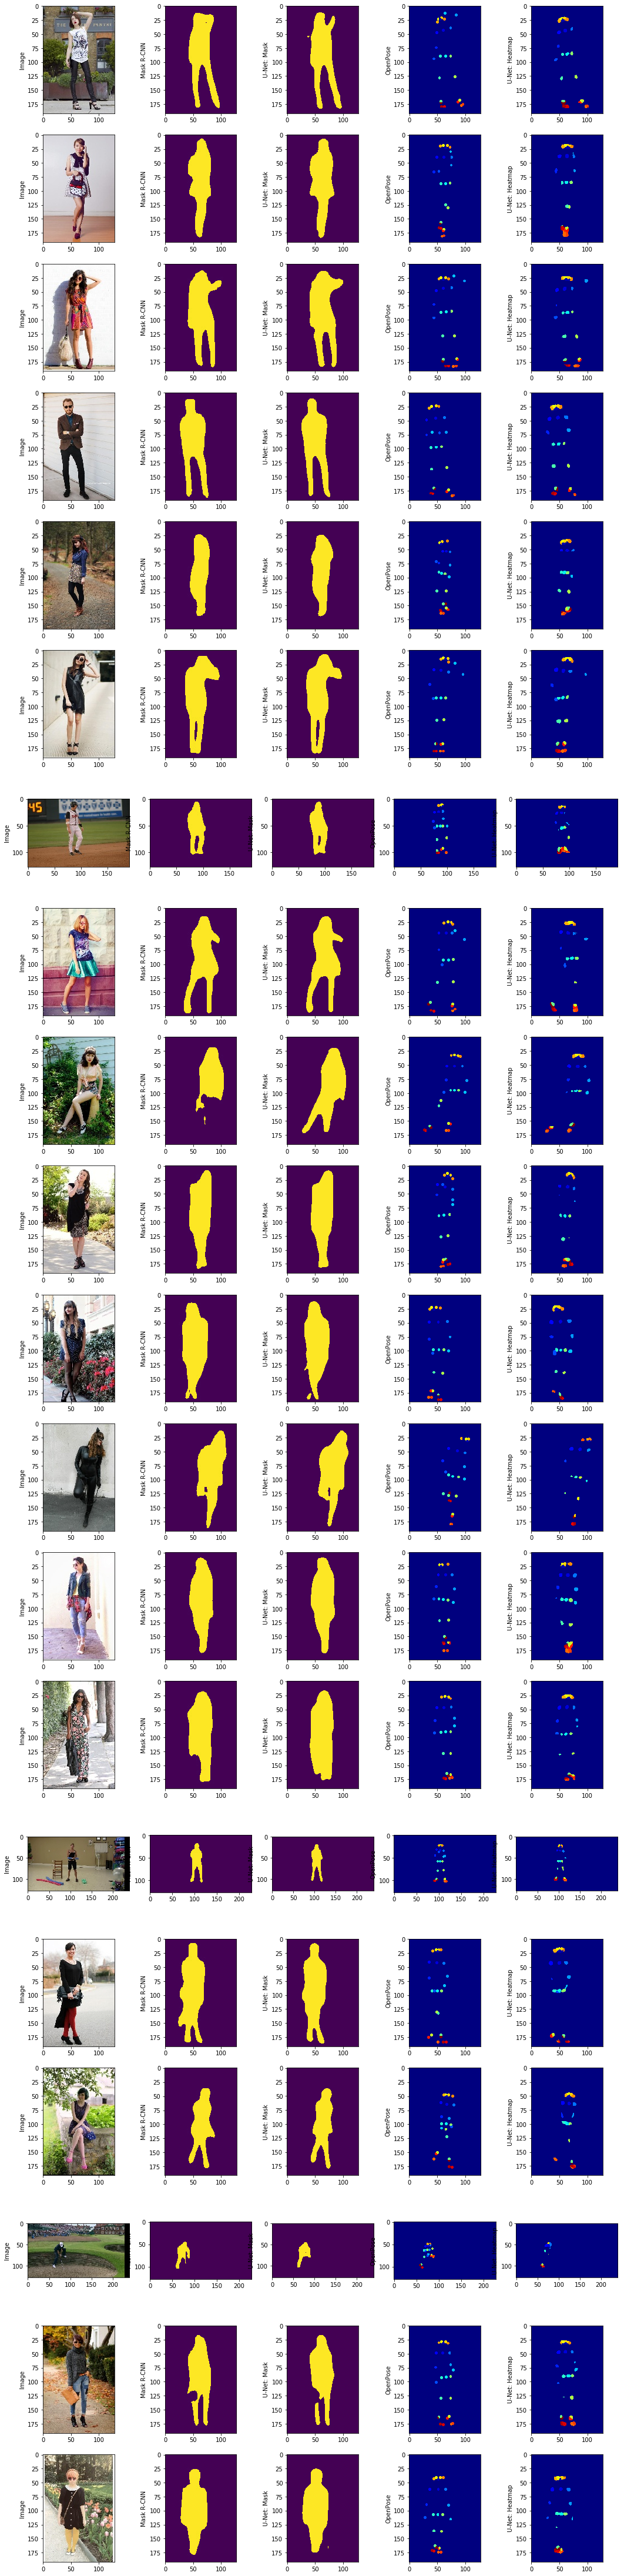

In [23]:
image_list = X_valid[40:60]

f, ax = plt.subplots(20,5, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
    X_batch /= 255

    r = X_batch.shape[0]
    c = X_batch.shape[1]
    r_pad = 0
    c_pad = 0

    while r % 16 != 0:
        r_pad += 1
        r += 1

    while c % 16 != 0:
        c_pad += 1
        c += 1

    X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
    ax[i,0].imshow(X_batch)
    X_batch = np.expand_dims(X_batch, axis=0)

    pred = model1.predict(X_batch)
    pred_1 = np.argmax(pred[0], axis=3)[0]
    pred_2 = np.argmax(pred[1], axis=3)

    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[c_]], 0))
    ax[i,2].imshow(pred_1)
    ax[i,3].imshow(np.load('SMALL_5K_HEATMAPSOFTMAX/' + images[image_list[c_]].replace('.jpg', '.npy'), 0), cmap='jet')
    ax[i,4].imshow(np.squeeze(pred_2), cmap='jet')

    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('U-Net: Mask')
    _ = ax[j,3].set_ylabel('OpenPose')
    _ = ax[j,4].set_ylabel('U-Net: Heatmap')